In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics, decomposition

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import Data_Prep.Graph_Data as gd
from Data_Prep.Graph_Data import Molecule_data
from math import sqrt
# from torch_geometric.nn import GATv2Conv
from models.GAT import GAT
# from optuna_v1.attenFP_v1 import AttentionConvNet

In [2]:
def createFoldsData():
    iy = 0
    folds = 10
    for fold in tqdm(range(folds)):
        df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
        df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
        smiles = df_train['SMILES']
#         codIds = df_train['CODID']
        band_gap = df_train['logS']
        band_gap = band_gap.to_numpy()

        smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
        band_gap_test = df_test['logS']
        band_gap_test = band_gap_test.to_numpy()


        smile_graph = {}
        band_gap_arr = []
        smiles_array = []

        for i,smile in enumerate(smiles):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph[smile] = g
                band_gap_arr.append(band_gap[i])
                smiles_array.append(smile)

        smile_graph_test = {}
        band_gap_arr_test = []
        smiles_array_test = []

        for i,smile in enumerate(smiles_test):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph_test[smile] = g
                band_gap_arr_test.append(band_gap_test[i])
                smiles_array_test.append(smile)

        train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
                                   smile_graph=smile_graph,smiles=smiles_array)

        test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(iy),y=band_gap_arr_test,
                                   smile_graph=smile_graph_test,smiles=smiles_array_test)

        iy+=1

In [3]:
df = pd.read_csv('Data_Prep/solubility_1.csv')
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
smiles = df['SMILES']
# codIds = df['CODID']
band_gap = df['logS']

In [5]:
band_gap = band_gap.to_numpy()

In [6]:
def createFoldsCsv():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10,shuffle = True, random_state = 2) #, random_state = 2
    ix = 0
    train1 = df
    for train_index, test_index in (kf.split(train1)):
        print ("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train,X_test=train1.iloc[train_index], train1.iloc[test_index]
        X_train.to_csv('New_fold/fold_'+str(ix)+'_'+'x_train.csv',index=False)
        X_test.to_csv('New_fold/fold_'+str(ix)+'_'+'x_test.csv',index=False)
        ix+=1
    createFoldsData()

In [7]:
processed_data_file_train = 'data/processed/' + 'train_data_set_fold_'+str(0)+'.pt'
processed_data_file_test = 'data/processed/'  + 'test_data_set_fold_'+str(0)+'.pt'
if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
        createFoldsCsv()

In [9]:
if torch.cuda.is_available():  
    device = "cuda:7"
    print("cuda:7")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:7


In [9]:
def train(model, optimizer,train_loader):
    train_labels = 0
    train_predictions = 0
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # out = model(data)
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("train : ", y.shape)
        loss = F.mse_loss(out1, y)
        loss.backward()
        optimizer.step()
#         train_labels += train_labels + y
#         train_predictions += train_predictions + out1
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return total_loss,sqrt(total_loss / total_examples)

In [10]:
@torch.no_grad()
def test(loader, model):
    # mse = []
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
#         total_preds = torch.cat((total_preds, out1.cpu()), 0)
#         total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples) #,total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [2]:
# Generate the model.

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0021931604377098835,
#                                weight_decay=1.2733069489371785e-05)
the_last_loss = 100
patience = 30
trigger_times = 0
count_loss_difference = 0
#LR = 0.005
learning_rate = 0.00688267742977242
weight_decay=0.000307616688331247
#LR = 0.0028894537419258915
LOG_INTERVAL = 20
NUM_EPOCHS = 200
results = []
TRAIN_BATCH_SIZE = 64

In [3]:
best_ret = []
best_mse = 0.80
best_ci = 0
best_epoch = -1

In [13]:
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
for fold in tqdm(range(folds)):
    model = GAT().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    result_file_name = 'result_' + str(fold) +  '.csv'
    
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    model
    
    
    train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
        test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          f'Test: {test_rmse:.4f} ') #f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse,test_rmse]
        
        train_losses.append(train_rmse)
        val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = test_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse,test_rmse] #, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 5.8143 Test: 1.3705 
Epoch: 001, Loss: 1.3472 Test: 1.2614 
Epoch: 002, Loss: 1.2670 Test: 1.1438 
Epoch: 003, Loss: 1.2546 Test: 1.3363 
trigger times: 1
Epoch: 004, Loss: 1.2435 Test: 1.1090 
Epoch: 005, Loss: 1.2269 Test: 1.0638 
Epoch: 006, Loss: 1.2317 Test: 1.0521 
Epoch: 007, Loss: 1.2502 Test: 1.0939 
trigger times: 1
Epoch: 008, Loss: 1.2059 Test: 1.0512 
Epoch: 009, Loss: 1.1986 Test: 1.1042 
trigger times: 1
Epoch: 010, Loss: 1.2268 Test: 1.0578 
trigger times: 2
Epoch: 011, Loss: 1.1726 Test: 1.0819 
trigger times: 3
Epoch: 012, Loss: 1.1697 Test: 1.0792 
trigger times: 4
Epoch: 013, Loss: 1.1650 Test: 1.0993 
trigger times: 5
Epoch: 014, Loss: 1.1785 Test: 1.1824 
trigger times: 6
Epoch: 015, Loss: 1.2084 Test: 1.0249 
Epoch: 016, Loss: 1.1658 Test: 1.1235 
trigger times: 1
Epoch: 017, Loss: 1.1814 Test: 1.2693 
trigger times: 2
Epoch: 018, Loss: 1.1722 Test: 1.0979 
trigger times: 3
Epoch: 019, Loss: 1.1545 Test: 1.0331 
trigger times: 4
Epoch: 020, Loss

Epoch: 028, Loss: 1.1555 Test: 1.1098 
trigger times: 2
Epoch: 029, Loss: 1.1163 Test: 1.2039 
trigger times: 3
Epoch: 030, Loss: 1.1307 Test: 1.1765 
trigger times: 4
Epoch: 031, Loss: 1.1541 Test: 1.1486 
trigger times: 5
Epoch: 032, Loss: 1.1305 Test: 1.1646 
trigger times: 6
Epoch: 033, Loss: 1.1779 Test: 1.1286 
trigger times: 7
Epoch: 034, Loss: 1.1247 Test: 1.1190 
trigger times: 8
Epoch: 035, Loss: 1.1090 Test: 1.0880 
trigger times: 9
Epoch: 036, Loss: 1.1492 Test: 1.2071 
trigger times: 10
Epoch: 037, Loss: 1.1693 Test: 1.1414 
trigger times: 11
Epoch: 038, Loss: 1.1731 Test: 1.2568 
trigger times: 12
Epoch: 039, Loss: 1.1211 Test: 1.1195 
trigger times: 13
Epoch: 040, Loss: 1.1119 Test: 1.1124 
trigger times: 14
Epoch: 041, Loss: 1.1205 Test: 1.0797 
trigger times: 15
Epoch: 042, Loss: 1.1340 Test: 1.2920 
trigger times: 16
Epoch: 043, Loss: 1.1795 Test: 1.0624 
trigger times: 17
Epoch: 044, Loss: 1.1090 Test: 1.1861 
trigger times: 18
Epoch: 045, Loss: 1.1343 Test: 1.1801 


Epoch: 045, Loss: 1.2447 Test: 1.0811 
Epoch: 046, Loss: 1.1351 Test: 1.1429 
trigger times: 1
Epoch: 047, Loss: 1.1758 Test: 1.1194 
trigger times: 2
Epoch: 048, Loss: 1.1357 Test: 1.3296 
trigger times: 3
Epoch: 049, Loss: 1.1784 Test: 1.3332 
trigger times: 4
Epoch: 050, Loss: 1.1761 Test: 1.0617 
Epoch: 051, Loss: 1.1611 Test: 1.1681 
trigger times: 1
Epoch: 052, Loss: 1.3058 Test: 1.3725 
trigger times: 2
Epoch: 053, Loss: 1.2176 Test: 1.0858 
trigger times: 3
Epoch: 054, Loss: 1.1189 Test: 1.0848 
trigger times: 4
Epoch: 055, Loss: 1.1552 Test: 1.1647 
trigger times: 5
Epoch: 056, Loss: 1.1299 Test: 1.0517 
Epoch: 057, Loss: 1.1141 Test: 1.0553 
trigger times: 1
Epoch: 058, Loss: 1.0971 Test: 1.0883 
trigger times: 2
Epoch: 059, Loss: 1.2250 Test: 2.2361 
trigger times: 3
Epoch: 060, Loss: 3.7980 Test: 1.1643 
trigger times: 4
Epoch: 061, Loss: 1.1765 Test: 1.0922 
trigger times: 5
Epoch: 062, Loss: 1.1083 Test: 1.0760 
trigger times: 6
Epoch: 063, Loss: 1.1159 Test: 1.1022 
trig

Epoch: 079, Loss: 1.0717 Test: 1.0825 
trigger times: 9
Epoch: 080, Loss: 1.0750 Test: 1.2554 
trigger times: 10
Epoch: 081, Loss: 1.0779 Test: 1.0683 
trigger times: 11
Epoch: 082, Loss: 1.0569 Test: 1.0526 
Epoch: 083, Loss: 1.0766 Test: 1.0612 
trigger times: 1
Epoch: 084, Loss: 1.0667 Test: 1.1590 
trigger times: 2
Epoch: 085, Loss: 1.0725 Test: 1.1424 
trigger times: 3
Epoch: 086, Loss: 1.0764 Test: 1.0681 
trigger times: 4
Epoch: 087, Loss: 1.0701 Test: 1.1097 
trigger times: 5
Epoch: 088, Loss: 1.0930 Test: 1.1321 
trigger times: 6
Epoch: 089, Loss: 1.1009 Test: 1.0560 
trigger times: 7
Epoch: 090, Loss: 1.0753 Test: 1.0772 
trigger times: 8
Epoch: 091, Loss: 1.0807 Test: 1.0662 
trigger times: 9
Epoch: 092, Loss: 1.0674 Test: 1.0667 
trigger times: 10
Epoch: 093, Loss: 1.0891 Test: 1.0496 
Epoch: 094, Loss: 1.0948 Test: 1.0765 
trigger times: 1
Epoch: 095, Loss: 1.1760 Test: 1.4299 
trigger times: 2
Epoch: 096, Loss: 1.1200 Test: 1.0390 
Epoch: 097, Loss: 1.1232 Test: 1.0629 
t

Epoch: 056, Loss: 1.1410 Test: 1.4216 
trigger times: 6
Epoch: 057, Loss: 1.1167 Test: 1.2145 
trigger times: 7
Epoch: 058, Loss: 1.1449 Test: 1.3082 
trigger times: 8
Epoch: 059, Loss: 1.1668 Test: 1.2384 
trigger times: 9
Epoch: 060, Loss: 1.1141 Test: 1.0538 
Epoch: 061, Loss: 1.0893 Test: 1.0981 
trigger times: 1
Epoch: 062, Loss: 1.2164 Test: 1.3621 
trigger times: 2
Epoch: 063, Loss: 1.1619 Test: 1.3981 
trigger times: 3
Epoch: 064, Loss: 1.1792 Test: 1.0532 
Epoch: 065, Loss: 1.0907 Test: 1.2955 
trigger times: 1
Epoch: 066, Loss: 1.2020 Test: 1.0766 
trigger times: 2
Epoch: 067, Loss: 1.1145 Test: 1.2679 
trigger times: 3
Epoch: 068, Loss: 1.1725 Test: 1.0674 
trigger times: 4
Epoch: 069, Loss: 1.1463 Test: 1.2440 
trigger times: 5
Epoch: 070, Loss: 1.2008 Test: 1.0943 
trigger times: 6
Epoch: 071, Loss: 1.1184 Test: 1.1068 
trigger times: 7
Epoch: 072, Loss: 1.2237 Test: 1.1045 
trigger times: 8
Epoch: 073, Loss: 1.0964 Test: 1.0273 
Epoch: 074, Loss: 1.1078 Test: 1.0330 
trig

Epoch: 061, Loss: 1.1274 Test: 1.2263 
trigger times: 16
Epoch: 062, Loss: 1.1593 Test: 1.2589 
trigger times: 17
Epoch: 063, Loss: 1.2331 Test: 2.3718 
trigger times: 18
Epoch: 064, Loss: 1.1977 Test: 1.0902 
trigger times: 19
Epoch: 065, Loss: 1.1120 Test: 1.0807 
trigger times: 20
Epoch: 066, Loss: 1.1281 Test: 1.2409 
trigger times: 21
Epoch: 067, Loss: 1.1151 Test: 1.1773 
trigger times: 22
Epoch: 068, Loss: 1.3342 Test: 1.0889 
trigger times: 23
Epoch: 069, Loss: 1.1260 Test: 1.1455 
trigger times: 24
Epoch: 070, Loss: 1.1073 Test: 1.0720 
Epoch: 071, Loss: 1.0960 Test: 1.1745 
trigger times: 1
Epoch: 072, Loss: 1.1925 Test: 1.2379 
trigger times: 2
Epoch: 073, Loss: 1.1215 Test: 1.1772 
trigger times: 3
Epoch: 074, Loss: 1.1390 Test: 1.1490 
trigger times: 4
Epoch: 075, Loss: 1.1304 Test: 1.0457 
Epoch: 076, Loss: 1.1311 Test: 1.3633 
trigger times: 1
Epoch: 077, Loss: 3.1306 Test: 1.0798 
trigger times: 2
Epoch: 078, Loss: 1.1297 Test: 1.1711 
trigger times: 3
Epoch: 079, Loss:

Epoch: 077, Loss: 1.0473 Test: 1.0072 
trigger times: 4
Epoch: 078, Loss: 1.0713 Test: 1.0192 
trigger times: 5
Epoch: 079, Loss: 1.0771 Test: 1.2675 
trigger times: 6
Epoch: 080, Loss: 1.0744 Test: 1.0664 
trigger times: 7
Epoch: 081, Loss: 1.0719 Test: 1.0944 
trigger times: 8
Epoch: 082, Loss: 1.0686 Test: 1.0294 
trigger times: 9
Epoch: 083, Loss: 1.0835 Test: 0.9697 
Epoch: 084, Loss: 1.0802 Test: 0.9985 
trigger times: 1
Epoch: 085, Loss: 1.0765 Test: 1.0354 
trigger times: 2
Epoch: 086, Loss: 1.0719 Test: 1.0195 
trigger times: 3
Epoch: 087, Loss: 1.0909 Test: 0.9717 
trigger times: 4
Epoch: 088, Loss: 1.0623 Test: 1.0056 
trigger times: 5
Epoch: 089, Loss: 1.0898 Test: 0.9845 
trigger times: 6
Epoch: 090, Loss: 1.0727 Test: 1.0446 
trigger times: 7
Epoch: 091, Loss: 1.0710 Test: 1.0070 
trigger times: 8
Epoch: 092, Loss: 1.0910 Test: 0.9976 
trigger times: 9
Epoch: 093, Loss: 1.0749 Test: 1.0465 
trigger times: 10
Epoch: 094, Loss: 1.0839 Test: 1.1124 
trigger times: 11
Epoch: 

In [14]:
format_float = "{:.2f}".format(best_rmse)

In [15]:
type(format_float)

str

In [16]:
resSt = results[0][1]

In [17]:
res_val = resSt

In [18]:
res_val

[1, 1.3471797181099583, 1.2614065361126983]

125
125
96
96
37
37
116
116
127
127
47
47
104
104
42
42
133
133
137
137


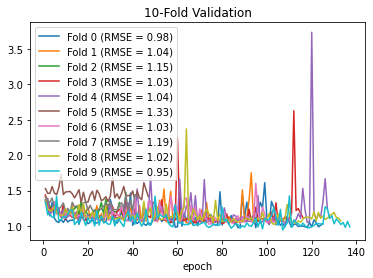

In [19]:
folds = 10
for fold in range(folds):
    train_loss_arr = []
    test_loss_arr = []
    for res in results[fold]:
        train_loss_arr.append(res[1])
        test_loss_arr.append(res[2])
    
    print(len(train_loss_arr))
    print(len(test_loss_arr))
    ax = plt.subplot(1,1,1)
    
    ax.WindowState = 'maximized';

    format_mae = "{:.2f}".format(best_rmse_arr[fold])
    
  #  ax.plot([e for e in range(1,len(train_loss_arr) + 1)], train_loss_arr, label="train_loss")
    ax.plot([e for e in range(1,len(test_loss_arr) + 1)],
            test_loss_arr, label="Fold " + str(fold) + " (RMSE = " + format_mae + ")")
    plt.xlabel("epoch")
    ax.title.set_text('10-Fold Validation')
    ax.legend()
    ax.figure.savefig('Visualization/'+str(fold)+'.png')

In [4]:
# whole data set as training dataset
def createTestData(path,filename,datasetname):
    iy = 0
#     folds = 10
#     for fold in tqdm(range(folds)):
#     df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
#     df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
#     smiles = df_train['SMILES']
#         codIds = df_train['CODID']
#     solubility = df_train['logS']
#     solubility = solubility.to_numpy()
    df_test = pd.read_csv(path + '/' + filename)
#     df_test  = pd.read_csv('New_fold/testset_novel.csv')
    smiles_test = df_test['SMILES']
#         codIds_test = df_test['CODID']
    solubility_test = df_test['logS']
    solubility_test = solubility_test.to_numpy()


#     smile_graph = {}
#     solubility_arr = []
#     smiles_array = []
    smile_graph_test = {}
    solubility_arr_test = []
    smiles_array_test = []

    for i,smile in enumerate(smiles_test):
        g = gd.smile_to_graph(smile)
        if g != None:
            smile_graph_test[smile] = g
            solubility_arr_test.append(smiles_test[i])
            smiles_array_test.append(smile)

#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
#                                smile_graph=smile_graph,smiles=smiles_array)

    noveltest_data = Molecule_data(root='data', dataset=datasetname,y=solubility_test,
                               smile_graph=smile_graph_test,smiles=smiles_array_test)
    return noveltest_data
#     iy+=1

In [5]:
@torch.no_grad()
def predicting(loader, model):
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        # out = model(data)
        # mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        # return float(torch.cat(mse, dim=0).mean().sqrt())
        y = data.y.view([-1])
        out1 = out.view([-1])
        # print("test : ", y.shape)
        test_loss = F.mse_loss(out1, y)
        # print("no of graphs: ", data.num_graphs)
        total_loss += float(test_loss) * data.num_graphs
        total_examples += data.num_graphs
        total_preds = torch.cat((total_preds, out.view(-1, 1).cpu()), 0)
        total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
#         print("total_labels : ", total_labels.shape)
#         print("total_preds : ", total_preds.shape)
        # mse.append(test_loss).cpu()
    # return test_loss,float(torch.cat(mse, dim=0).mean().sqrt())
    return total_loss,sqrt(total_loss / total_examples),total_labels.numpy().flatten(),total_preds.numpy().flatten()

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  0.5620946217480056
Test RMSE:  1.4742943701303723
Test R2:  0.5066979566343093
Test RMSE:  1.5630250354992792
Test R2:  0.6857048644607735
Test RMSE:  1.225492850445466
Test R2:  0.4688989160974357
Test RMSE:  1.5537526226757463
Test R2:  0.3539823846078044
Test RMSE:  1.7413094724735096
Test R2:  0.6178359931804998
Test RMSE:  1.346382407225885
Test R2:  0.5027372081599021
Test RMSE:  1.556597472247931
Test R2:  0.7067893782337602
Test RMSE:  1.221677728277639
Test R2:  0.45442047310056144
Test RMSE:  1.6057811153938162
Test R2:  0.5485235517923928
Test RMSE:  1.5479478454289926


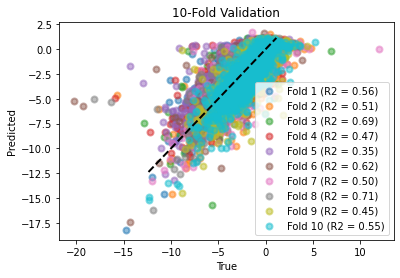

In [22]:
# 10 fold cross validation set results. Calculating pearson correlations.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
fig = plt.figure()
for fold in tqdm(range(folds)):
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 40
    test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
#     result_file_name = 'novelresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     model.load_state_dict(torch.load(model_file_name))
    
    test_loss,test_rmse, true, prediction = predicting(test_loader, model)
    
    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE: ', test_rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.5, 
                label='Fold %d (R2 = %0.2f)' % (fold+1,score))
plt.plot([min(prediction),max(true)], [min(prediction),max(true)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('10-Fold Validation')
plt.legend()
plt.savefig('TestR2.png')
plt.show()
# avg = bestrmsesum/10
# print('10 fold avg is : ', avg)

In [23]:
# training whole dataset. first loading each fold model and train on whole dataset
folds = 10
results = []
best_rmse_arr = []
scores = []
true_val = []
pred_val = []
wholetrain_data = createTestData('Data_Prep','solubility_1.csv','solubility_1')
for fold in tqdm(range(folds)):
    wholetrain_loader  = DataLoader(wholetrain_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    load_model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    result_file_name = 'wholetrainresult_' + str(fold) +  '.csv'
    checkpoint = torch.load(load_model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
#     test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
#     TRAIN_BATCH_SIZE = 64
    
#     train_loader   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     test_loader  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,
#                     num_layers=3, num_timesteps=2,
#                     dropout=0.047352327938708194).to(device)
    best_ret = []
    
#     model = model.cuda(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss,train_rmse=train(model, optimizer,train_loader)
#         test_loss,test_rmse = test(test_loader, model)
#         score = metrics.r2_score(true, prediction)
#         , true, prediction
        
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} '
          ) #f'Test: {test_rmse:.4f} 'f'score: {score:.4f} '   
        
        ret = [epoch,train_rmse]
        
        train_losses.append(train_rmse)
#         val_losses.append(test_rmse)
#         scores.append(score)
        # Early Stopping
        the_current_loss = train_rmse   #.item()
        best_ret.append(ret)
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
    
            if trigger_times >= 200:   #patience
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_rmse] #, ,test_rmse, score
            trigger_times = 0
            the_last_loss = the_current_loss
            best_rmse = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)
        # Early stopping
#         the_current_loss = test_loss.item()
        
#         best_ret.append(ret)
        
#         if the_current_loss > the_last_loss:
#             trigger_times += 1
#             print('trigger times:', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 break
#         else:
#             ret = [epoch,train_loss,test_loss.item()]
#             trigger_times = 0
#             best_mae = the_current_loss
#             the_last_loss = the_current_loss
            
#             torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_rmse_arr.append(best_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 000, Loss: 1.4616 
Epoch: 001, Loss: 1.2266 
Epoch: 002, Loss: 1.2681 
trigger times: 1
Epoch: 003, Loss: 1.2538 
trigger times: 2
Epoch: 004, Loss: 1.2525 
trigger times: 3
Epoch: 005, Loss: 1.2969 
trigger times: 4
Epoch: 006, Loss: 1.2833 
trigger times: 5
Epoch: 007, Loss: 1.2495 
trigger times: 6
Epoch: 008, Loss: 1.2655 
trigger times: 7
Epoch: 009, Loss: 1.2597 
trigger times: 8
Epoch: 010, Loss: 1.3201 
trigger times: 9
Epoch: 011, Loss: 1.2658 
trigger times: 10
Epoch: 012, Loss: 1.2386 
trigger times: 11
Epoch: 013, Loss: 1.2260 
Epoch: 014, Loss: 1.2200 
Epoch: 015, Loss: 1.2598 
trigger times: 1
Epoch: 016, Loss: 1.2413 
trigger times: 2
Epoch: 017, Loss: 1.3764 
trigger times: 3
Epoch: 018, Loss: 1.2098 
Epoch: 019, Loss: 1.2302 
trigger times: 1
Epoch: 020, Loss: 1.2934 
trigger times: 2
Epoch: 021, Loss: 1.4111 
trigger times: 3
Epoch: 022, Loss: 1.2686 
trigger times: 4
Epoch: 023, Loss: 1.2925 
trigger times: 5
Epoch: 024, Loss: 1.2284 
trigger times: 6
Epoch: 0

Epoch: 191, Loss: 1.2460 
trigger times: 33
Epoch: 192, Loss: 1.2491 
trigger times: 34
Epoch: 193, Loss: 1.2301 
trigger times: 35
Epoch: 194, Loss: 1.3075 
trigger times: 36
Epoch: 195, Loss: 1.2526 
trigger times: 37
Epoch: 196, Loss: 1.2396 
trigger times: 38
Epoch: 197, Loss: 1.2483 
trigger times: 39
Epoch: 198, Loss: 1.2436 
trigger times: 40
Epoch: 199, Loss: 1.1700 
Epoch: 000, Loss: 1.4859 
Epoch: 001, Loss: 1.2759 
Epoch: 002, Loss: 1.2082 
Epoch: 003, Loss: 1.2597 
trigger times: 1
Epoch: 004, Loss: 1.2177 
trigger times: 2
Epoch: 005, Loss: 1.2572 
trigger times: 3
Epoch: 006, Loss: 1.2438 
trigger times: 4
Epoch: 007, Loss: 1.2260 
trigger times: 5
Epoch: 008, Loss: 1.2468 
trigger times: 6
Epoch: 009, Loss: 1.3042 
trigger times: 7
Epoch: 010, Loss: 1.2503 
trigger times: 8
Epoch: 011, Loss: 1.2387 
trigger times: 9
Epoch: 012, Loss: 1.3132 
trigger times: 10
Epoch: 013, Loss: 1.2321 
trigger times: 11
Epoch: 014, Loss: 1.2461 
trigger times: 12
Epoch: 015, Loss: 1.3400 

Epoch: 182, Loss: 1.2583 
trigger times: 129
Epoch: 183, Loss: 1.2254 
trigger times: 130
Epoch: 184, Loss: 1.2115 
trigger times: 131
Epoch: 185, Loss: 1.1967 
trigger times: 132
Epoch: 186, Loss: 1.2260 
trigger times: 133
Epoch: 187, Loss: 1.1654 
trigger times: 134
Epoch: 188, Loss: 1.2637 
trigger times: 135
Epoch: 189, Loss: 1.1812 
trigger times: 136
Epoch: 190, Loss: 1.2140 
trigger times: 137
Epoch: 191, Loss: 1.2122 
trigger times: 138
Epoch: 192, Loss: 1.1755 
trigger times: 139
Epoch: 193, Loss: 1.2529 
trigger times: 140
Epoch: 194, Loss: 1.2638 
trigger times: 141
Epoch: 195, Loss: 1.1976 
trigger times: 142
Epoch: 196, Loss: 1.1530 
trigger times: 143
Epoch: 197, Loss: 1.1723 
trigger times: 144
Epoch: 198, Loss: 1.1929 
trigger times: 145
Epoch: 199, Loss: 1.2657 
trigger times: 146
Epoch: 000, Loss: 1.6942 
Epoch: 001, Loss: 1.2859 
Epoch: 002, Loss: 1.3251 
trigger times: 1
Epoch: 003, Loss: 1.2722 
Epoch: 004, Loss: 1.2297 
Epoch: 005, Loss: 1.3154 
trigger times: 1


Epoch: 176, Loss: 1.2364 
trigger times: 48
Epoch: 177, Loss: 1.1735 
trigger times: 49
Epoch: 178, Loss: 1.2911 
trigger times: 50
Epoch: 179, Loss: 1.2321 
trigger times: 51
Epoch: 180, Loss: 1.2125 
trigger times: 52
Epoch: 181, Loss: 1.2411 
trigger times: 53
Epoch: 182, Loss: 1.2293 
trigger times: 54
Epoch: 183, Loss: 1.3161 
trigger times: 55
Epoch: 184, Loss: 1.2011 
trigger times: 56
Epoch: 185, Loss: 1.2056 
trigger times: 57
Epoch: 186, Loss: 1.2372 
trigger times: 58
Epoch: 187, Loss: 1.2567 
trigger times: 59
Epoch: 188, Loss: 1.2078 
trigger times: 60
Epoch: 189, Loss: 1.2373 
trigger times: 61
Epoch: 190, Loss: 1.3177 
trigger times: 62
Epoch: 191, Loss: 1.2299 
trigger times: 63
Epoch: 192, Loss: 1.2038 
trigger times: 64
Epoch: 193, Loss: 1.2043 
trigger times: 65
Epoch: 194, Loss: 1.2807 
trigger times: 66
Epoch: 195, Loss: 1.3004 
trigger times: 67
Epoch: 196, Loss: 1.2810 
trigger times: 68
Epoch: 197, Loss: 1.2969 
trigger times: 69
Epoch: 198, Loss: 1.2031 
trigge

Epoch: 166, Loss: 1.2802 
trigger times: 104
Epoch: 167, Loss: 1.2214 
trigger times: 105
Epoch: 168, Loss: 1.2034 
trigger times: 106
Epoch: 169, Loss: 1.2304 
trigger times: 107
Epoch: 170, Loss: 1.3291 
trigger times: 108
Epoch: 171, Loss: 1.3174 
trigger times: 109
Epoch: 172, Loss: 1.2337 
trigger times: 110
Epoch: 173, Loss: 1.2949 
trigger times: 111
Epoch: 174, Loss: 1.2201 
trigger times: 112
Epoch: 175, Loss: 1.1579 
Epoch: 176, Loss: 1.1735 
trigger times: 1
Epoch: 177, Loss: 1.2030 
trigger times: 2
Epoch: 178, Loss: 1.2454 
trigger times: 3
Epoch: 179, Loss: 1.2225 
trigger times: 4
Epoch: 180, Loss: 1.2142 
trigger times: 5
Epoch: 181, Loss: 1.2871 
trigger times: 6
Epoch: 182, Loss: 1.2477 
trigger times: 7
Epoch: 183, Loss: 1.1874 
trigger times: 8
Epoch: 184, Loss: 1.3012 
trigger times: 9
Epoch: 185, Loss: 1.2956 
trigger times: 10
Epoch: 186, Loss: 1.2082 
trigger times: 11
Epoch: 187, Loss: 1.2187 
trigger times: 12
Epoch: 188, Loss: 1.1994 
trigger times: 13
Epoch:

Epoch: 155, Loss: 1.1776 
trigger times: 131
Epoch: 156, Loss: 1.1946 
trigger times: 132
Epoch: 157, Loss: 1.1737 
trigger times: 133
Epoch: 158, Loss: 1.2733 
trigger times: 134
Epoch: 159, Loss: 1.2289 
trigger times: 135
Epoch: 160, Loss: 1.1986 
trigger times: 136
Epoch: 161, Loss: 1.1995 
trigger times: 137
Epoch: 162, Loss: 1.2263 
trigger times: 138
Epoch: 163, Loss: 1.3196 
trigger times: 139
Epoch: 164, Loss: 1.2307 
trigger times: 140
Epoch: 165, Loss: 6.7957 
trigger times: 141
Epoch: 166, Loss: 1.1913 
trigger times: 142
Epoch: 167, Loss: 1.1439 
trigger times: 143
Epoch: 168, Loss: 1.1165 
Epoch: 169, Loss: 1.1332 
trigger times: 1
Epoch: 170, Loss: 1.1266 
trigger times: 2
Epoch: 171, Loss: 1.1181 
trigger times: 3
Epoch: 172, Loss: 1.1130 
Epoch: 173, Loss: 1.1064 
Epoch: 174, Loss: 1.1056 
Epoch: 175, Loss: 1.1150 
trigger times: 1
Epoch: 176, Loss: 1.1295 
trigger times: 2
Epoch: 177, Loss: 1.1121 
trigger times: 3
Epoch: 178, Loss: 1.1069 
trigger times: 4
Epoch: 179

Epoch: 146, Loss: 1.4649 
trigger times: 132
Epoch: 147, Loss: 1.5341 
trigger times: 133
Epoch: 148, Loss: 1.1807 
trigger times: 134
Epoch: 149, Loss: 1.1697 
trigger times: 135
Epoch: 150, Loss: 1.3011 
trigger times: 136
Epoch: 151, Loss: 1.1732 
trigger times: 137
Epoch: 152, Loss: 1.1858 
trigger times: 138
Epoch: 153, Loss: 1.2214 
trigger times: 139
Epoch: 154, Loss: 1.2000 
trigger times: 140
Epoch: 155, Loss: 1.1857 
trigger times: 141
Epoch: 156, Loss: 1.2210 
trigger times: 142
Epoch: 157, Loss: 1.2486 
trigger times: 143
Epoch: 158, Loss: 1.2136 
trigger times: 144
Epoch: 159, Loss: 1.2142 
trigger times: 145
Epoch: 160, Loss: 1.1896 
trigger times: 146
Epoch: 161, Loss: 1.2111 
trigger times: 147
Epoch: 162, Loss: 1.2516 
trigger times: 148
Epoch: 163, Loss: 1.2878 
trigger times: 149
Epoch: 164, Loss: 1.1885 
trigger times: 150
Epoch: 165, Loss: 1.2693 
trigger times: 151
Epoch: 166, Loss: 1.2250 
trigger times: 152
Epoch: 167, Loss: 1.6722 
trigger times: 153
Epoch: 168

Epoch: 136, Loss: 1.2013 
trigger times: 36
Epoch: 137, Loss: 1.3064 
trigger times: 37
Epoch: 138, Loss: 1.2259 
trigger times: 38
Epoch: 139, Loss: 1.2796 
trigger times: 39
Epoch: 140, Loss: 1.2557 
trigger times: 40
Epoch: 141, Loss: 1.2473 
trigger times: 41
Epoch: 142, Loss: 1.1844 
trigger times: 42
Epoch: 143, Loss: 1.2409 
trigger times: 43
Epoch: 144, Loss: 1.2151 
trigger times: 44
Epoch: 145, Loss: 1.1872 
trigger times: 45
Epoch: 146, Loss: 1.2779 
trigger times: 46
Epoch: 147, Loss: 1.1812 
trigger times: 47
Epoch: 148, Loss: 1.2199 
trigger times: 48
Epoch: 149, Loss: 1.2180 
trigger times: 49
Epoch: 150, Loss: 1.2293 
trigger times: 50
Epoch: 151, Loss: 1.2681 
trigger times: 51
Epoch: 152, Loss: 1.2309 
trigger times: 52
Epoch: 153, Loss: 1.2895 
trigger times: 53
Epoch: 154, Loss: 2.4648 
trigger times: 54
Epoch: 155, Loss: 1.4302 
trigger times: 55
Epoch: 156, Loss: 1.1562 
Epoch: 157, Loss: 1.1545 
Epoch: 158, Loss: 1.1204 
Epoch: 159, Loss: 1.1248 
trigger times: 1

Epoch: 132, Loss: 1.2372 
trigger times: 28
Epoch: 133, Loss: 1.3076 
trigger times: 29
Epoch: 134, Loss: 1.2424 
trigger times: 30
Epoch: 135, Loss: 1.2000 
trigger times: 31
Epoch: 136, Loss: 1.2762 
trigger times: 32
Epoch: 137, Loss: 1.3156 
trigger times: 33
Epoch: 138, Loss: 1.1996 
trigger times: 34
Epoch: 139, Loss: 1.1940 
trigger times: 35
Epoch: 140, Loss: 1.2338 
trigger times: 36
Epoch: 141, Loss: 1.2646 
trigger times: 37
Epoch: 142, Loss: 1.3194 
trigger times: 38
Epoch: 143, Loss: 1.2281 
trigger times: 39
Epoch: 144, Loss: 1.1989 
trigger times: 40
Epoch: 145, Loss: 1.2948 
trigger times: 41
Epoch: 146, Loss: 1.2243 
trigger times: 42
Epoch: 147, Loss: 1.2441 
trigger times: 43
Epoch: 148, Loss: 1.2854 
trigger times: 44
Epoch: 149, Loss: 1.3608 
trigger times: 45
Epoch: 150, Loss: 1.2779 
trigger times: 46
Epoch: 151, Loss: 1.3022 
trigger times: 47
Epoch: 152, Loss: 1.1882 
trigger times: 48
Epoch: 153, Loss: 1.2175 
trigger times: 49
Epoch: 154, Loss: 1.1918 
trigge

Epoch: 125, Loss: 1.2227 
trigger times: 71
Epoch: 126, Loss: 1.2632 
trigger times: 72
Epoch: 127, Loss: 1.1817 
trigger times: 73
Epoch: 128, Loss: 1.2985 
trigger times: 74
Epoch: 129, Loss: 1.2762 
trigger times: 75
Epoch: 130, Loss: 1.2579 
trigger times: 76
Epoch: 131, Loss: 1.2276 
trigger times: 77
Epoch: 132, Loss: 1.2158 
trigger times: 78
Epoch: 133, Loss: 1.1972 
trigger times: 79
Epoch: 134, Loss: 1.2213 
trigger times: 80
Epoch: 135, Loss: 1.2257 
trigger times: 81
Epoch: 136, Loss: 1.2163 
trigger times: 82
Epoch: 137, Loss: 1.2718 
trigger times: 83
Epoch: 138, Loss: 1.3043 
trigger times: 84
Epoch: 139, Loss: 1.1930 
trigger times: 85
Epoch: 140, Loss: 1.2437 
trigger times: 86
Epoch: 141, Loss: 1.2413 
trigger times: 87
Epoch: 142, Loss: 1.1785 
trigger times: 88
Epoch: 143, Loss: 1.2020 
trigger times: 89
Epoch: 144, Loss: 1.2230 
trigger times: 90
Epoch: 145, Loss: 1.2459 
trigger times: 91
Epoch: 146, Loss: 1.2352 
trigger times: 92
Epoch: 147, Loss: 1.2398 
trigge

Epoch: 114, Loss: 1.2567 
trigger times: 8
Epoch: 115, Loss: 1.2407 
trigger times: 9
Epoch: 116, Loss: 1.3123 
trigger times: 10
Epoch: 117, Loss: 1.2391 
trigger times: 11
Epoch: 118, Loss: 1.2208 
trigger times: 12
Epoch: 119, Loss: 1.2893 
trigger times: 13
Epoch: 120, Loss: 1.3509 
trigger times: 14
Epoch: 121, Loss: 1.2198 
trigger times: 15
Epoch: 122, Loss: 1.1869 
trigger times: 16
Epoch: 123, Loss: 1.2188 
trigger times: 17
Epoch: 124, Loss: 1.2582 
trigger times: 18
Epoch: 125, Loss: 1.2827 
trigger times: 19
Epoch: 126, Loss: 1.2402 
trigger times: 20
Epoch: 127, Loss: 1.3486 
trigger times: 21
Epoch: 128, Loss: 1.1821 
Epoch: 129, Loss: 1.2206 
trigger times: 1
Epoch: 130, Loss: 1.2695 
trigger times: 2
Epoch: 131, Loss: 1.1939 
trigger times: 3
Epoch: 132, Loss: 1.2534 
trigger times: 4
Epoch: 133, Loss: 1.3570 
trigger times: 5
Epoch: 134, Loss: 1.2325 
trigger times: 6
Epoch: 135, Loss: 1.2116 
trigger times: 7
Epoch: 136, Loss: 1.1551 
Epoch: 137, Loss: 1.2367 
trigger

In [24]:
noveltest_data = createTestData('New_fold','testset_novel.csv','testset_novel')
# noveltest_data = Molecule_data(root='data', dataset='testset_novel',y=None,smile_graph=None,smiles=None)
# noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
#     model = AttentiveFP(in_channels=112, hidden_channels=279, out_channels=1,

In [25]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
# fig = plt.figure()
# for fold in tqdm(range(folds)):
# val_losses = []
# train_losses = []
# mae_arr = []
# patience = 30
# trigger_times = 0
# the_last_loss = 100
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  0.2441388813170452
Test RMSE: 0.7720296743377252
Test R2:  0.2066908162048513
Test RMSE: 0.7909230495958045
Test R2:  0.28779230190016036
Test RMSE: 0.7494045914127789
Test R2:  0.31317453902074344
Test RMSE: 0.7359294267280441
Test R2:  0.050747526463346904
Test RMSE: 0.8651748188954784
Test R2:  0.38613311740911693
Test RMSE: 0.6957450121564744
Test R2:  0.264583100733769
Test RMSE: 0.7615173464832588
Test R2:  -0.31521026387077855
Test RMSE: 1.0183817496290868
Test R2:  0.2970653041295014
Test RMSE: 0.7445099482336007
Test R2:  -1.9089318419911594
Test RMSE: 1.5145365159023763


In [26]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

Test R2:  -2.213837852121167
Test RMSE: 1.5919336927158065
Test R2:  -1.1998890269391462
Test RMSE: 1.3170837560594881
Test R2:  0.2443747764397144
Test RMSE: 0.771909147735033
Test R2:  -1.2368285572387094
Test RMSE: 1.328095604066343
Test R2:  -1.9071088578044404
Test RMSE: 1.5140619772013577
Test R2:  0.3000484569395985
Test RMSE: 0.7429284663465879
Test R2:  -0.7771527538869438
Test RMSE: 1.1837919465863647
Test R2:  0.4070820612865619
Test RMSE: 0.6837704021541257
Test R2:  -0.9272699348565427
Test RMSE: 1.2327763309177067
Test R2:  -0.4539832569231388
Test RMSE: 1.0707613706837804


In [ ]:
# GNN Explainer test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
# fig = plt.figure()
# for fold in tqdm(range(folds)):
# val_losses = []
# train_losses = []
# mae_arr = []
# patience = 30
# trigger_times = 0
# the_last_loss = 100
for fold in tqdm(range(folds)):
    noveltest_loader  = DataLoader(noveltest_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(noveltest_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('Test R2: ', score)
    print('Test RMSE:', test_rmse)

In [6]:
DLS100_data = createTestData('New_fold','DLS100.csv','DLS100')

Pre-processed data data/processed/DLS100.pt not found, doing pre-processing...
Converting SMILES to graph: 1/100
Converting SMILES to graph: 2/100
Converting SMILES to graph: 3/100
Converting SMILES to graph: 4/100
Converting SMILES to graph: 5/100
Converting SMILES to graph: 6/100
Converting SMILES to graph: 7/100
Converting SMILES to graph: 8/100
Converting SMILES to graph: 9/100
Converting SMILES to graph: 10/100
Converting SMILES to graph: 11/100
Converting SMILES to graph: 12/100
Converting SMILES to graph: 13/100
Converting SMILES to graph: 14/100
Converting SMILES to graph: 15/100
Converting SMILES to graph: 16/100
Converting SMILES to graph: 17/100
Converting SMILES to graph: 18/100
Converting SMILES to graph: 19/100
Converting SMILES to graph: 20/100
Converting SMILES to graph: 21/100
Converting SMILES to graph: 22/100
Converting SMILES to graph: 23/100
Converting SMILES to graph: 24/100
Converting SMILES to graph: 25/100
Converting SMILES to graph: 26/100
Converting SMILES to

In [10]:
# test novel dataset on whole trained model.
from sklearn import model_selection, preprocessing, metrics, decomposition
import matplotlib.pyplot as plt
folds = 10
results = []
best_rmse_arr = []
bestrmsesum = 0
scores = []
true_val = []
pred_val = []
# fig = plt.figure()
# for fold in tqdm(range(folds)):
# val_losses = []
# train_losses = []
# mae_arr = []
# patience = 30
# trigger_times = 0
# the_last_loss = 100
for fold in tqdm(range(folds)):
    DLS100_loader  = DataLoader(DLS100_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = GAT().to(device)
    # model = define_model(trial).to(device)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # optimizer = torch.optim.Adam(model.parameters(), lr=.0023467,
    #                              weight_decay=.00095)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.007531829,
#                                    weight_decay=0.000252036)
#     model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
#                     edge_dim=10, num_layers=2, num_timesteps=2,
#                     dropout=0.2).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 30
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/wholetrainmodel_' +  str(fold) +  '.model'
    checkpoint = torch.load(model_file_name, map_location=torch.device(device))
    model.load_state_dict(checkpoint)
#     train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_loss,test_rmse, true, prediction = predicting(DLS100_loader, model)

    best_ret = []
    bestrmsesum = bestrmsesum + test_rmse
    results.append(best_ret)
    #best_rmse_arr.append(best_rmse)
    true_val.append(true)
    pred_val.append(prediction)
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    print('DLS100 Test R2: ', score)
    print('DLS100 Test RMSE:', test_rmse)

  0%|          | 0/10 [00:00<?, ?it/s]

DLS100 Test R2:  0.6392118967183169
DLS100 Test RMSE: 1.0240424987311114
DLS100 Test R2:  0.4428526469382511
DLS100 Test RMSE: 1.2725560138867402
DLS100 Test R2:  0.6300548759186226
DLS100 Test RMSE: 1.0369564539926988
DLS100 Test R2:  0.5125976712366211
DLS100 Test RMSE: 1.1902430925591485
DLS100 Test R2:  0.6107955384835786
DLS100 Test RMSE: 1.063606023133415
DLS100 Test R2:  0.5747910743160598
DLS100 Test RMSE: 1.1117139761226449
DLS100 Test R2:  0.4825179561162708
DLS100 Test RMSE: 1.2264208669346681
DLS100 Test R2:  0.6331663765364391
DLS100 Test RMSE: 1.0325864812918775
DLS100 Test R2:  0.5358126529418485
DLS100 Test RMSE: 1.1615516260195895
DLS100 Test R2:  0.6005907671592549
DLS100 Test RMSE: 1.0774594051918736
